# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [231]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [232]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter =';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter =';')

In [233]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [234]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [235]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [236]:
# Identify missing or unknown data values and convert them to NaNs.
for abcd in range(len(feat_info)):
    feat_info['missing_or_unknown'][abcd] = feat_info['missing_or_unknown'][abcd].strip('[]').split(',')


In [237]:
for abcd in feat_info.index:
    for abc in range(len(feat_info['missing_or_unknown'][abcd])):
        try:
            feat_info['missing_or_unknown'][abcd][abc] =  int(feat_info['missing_or_unknown'][abcd][abc])
        except:
            continue
    azdias.loc[:, feat_info.loc[abcd,'attribute']].replace(feat_info.loc[abcd,'missing_or_unknown'], np.nan, inplace=True)


        
 

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

(array([ 39.,  40.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([ 0.        ,  0.09975764,  0.19951527,  0.29927291,  0.39903054,
         0.49878818,  0.59854582,  0.69830345,  0.79806109,  0.89781872,
         0.99757636]),
 <a list of 10 Patch objects>)

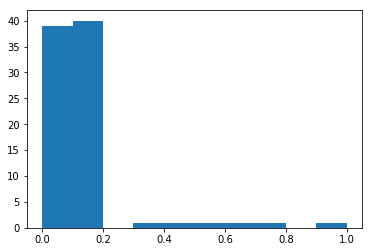

In [238]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
plt.hist(azdias.isnull().sum()/len(azdias))



In [239]:
# Investigate patterns in the amount of missing data in each column.
cols = []
for i in azdias.columns:
    if(azdias[i].isnull().sum()/len(azdias[i]) > 0.4):
        print(i,'',azdias[i].isnull().sum()/len(azdias[i]))
        cols.append(i)  

AGER_TYP  0.769554352961
GEBURTSJAHR  0.440202822869
TITEL_KZ  0.997576358726
KK_KUNDENTYP  0.655967487301
KBA05_BAUMAX  0.534686682652


In [240]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(cols, axis = 1, inplace = True)

In [241]:
azdias.shape

(891221, 80)

#### Discussion 1.1.2: Assess Missing Data in Each Column

From the histogram we can see that 20 % columns have missing values greator than 35 % of the their total percentage, the remaining columns have missing values less than 5 % of their total. Thus it is ideal to drop columns AGER_TYP, GEBURTSJAHR, TITEL_KZ, KK_KUNDENTYP, KBA05_BAUMAX, imputing these columns can add a bias to the data.      

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [242]:
# How much data is missing in each row of the dataset?
azdias.isnull().sum(axis = 1)/azdias.shape[1]

0         0.5500
1         0.0125
2         0.0000
3         0.0875
4         0.0000
5         0.0000
6         0.0125
7         0.0000
8         0.0000
9         0.0000
10        0.0000
11        0.6000
12        0.0750
13        0.1000
14        0.6000
15        0.1000
16        0.0750
17        0.6000
18        0.0500
19        0.0125
20        0.1375
21        0.0125
22        0.0125
23        0.1000
24        0.6000
25        0.0625
26        0.2500
27        0.0000
28        0.0000
29        0.0250
           ...  
891191    0.0000
891192    0.0000
891193    0.0000
891194    0.0000
891195    0.0125
891196    0.0000
891197    0.0000
891198    0.0000
891199    0.0125
891200    0.0000
891201    0.0000
891202    0.0125
891203    0.1875
891204    0.0000
891205    0.0000
891206    0.0000
891207    0.0000
891208    0.0375
891209    0.0125
891210    0.0125
891211    0.0000
891212    0.0000
891213    0.0000
891214    0.0000
891215    0.0125
891216    0.0375
891217    0.0500
891218    0.06

In [243]:
# How much data is missing in each row of the dataset?
row_index = azdias.isnull().sum(axis=1).index
nan_count = azdias.isnull().sum(axis=1).values

In [244]:
nan_df = pd.DataFrame()
nan_df['row_index'] = row_index
nan_df['nan_count'] = nan_count

(array([  6.95303000e+05,   7.81310000e+04,   1.33840000e+04,
          9.96000000e+03,   1.10100000e+03,   1.77000000e+02,
          1.11940000e+04,   7.84200000e+03,   2.79500000e+04,
          4.61790000e+04]),
 array([  0.   ,   6.125,  12.25 ,  18.375,  24.5  ,  30.625,  36.75 ,
         42.875,  49.   ,  55.125,  61.25 ]),
 <a list of 10 Patch objects>)

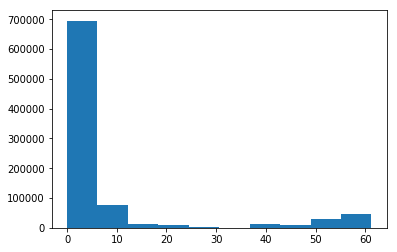

In [245]:
plt.hist(nan_df['nan_count']/len(azdias.columns) * 100)

(array([  6.95303000e+05,   7.81310000e+04,   1.33840000e+04,
          9.96000000e+03,   1.10100000e+03,   1.77000000e+02,
          1.11940000e+04,   7.84200000e+03,   2.79500000e+04,
          4.61790000e+04]),
 array([  0. ,   4.9,   9.8,  14.7,  19.6,  24.5,  29.4,  34.3,  39.2,
         44.1,  49. ]),
 <a list of 10 Patch objects>)

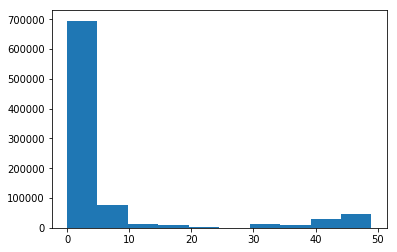

In [246]:
plt.hist(nan_df['nan_count'])

In [247]:
len(nan_df[(nan_df[25 > nan_df[nan_df['nan_count'] > 0]]['nan_count']).notna()]['nan_count'] )

344786

In [248]:
len(nan_df[(nan_df[50 > nan_df[nan_df['nan_count'] > 25]]['nan_count']).notna()]['nan_count'] )

93281

In [249]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 25
low_range = pd.DataFrame()
high_range = pd.DataFrame()
low_range['NullValues_Low'] =  nan_df[nan_df['nan_count'] < threshold ]['nan_count']
high_range['NullValues_high'] = nan_df[nan_df['nan_count'] >= threshold ]['nan_count']

In [250]:
range_low = azdias[nan_df['nan_count'] < threshold]
range_high = azdias[nan_df['nan_count'] >= threshold]

In [251]:
range_low.shape

(797879, 80)

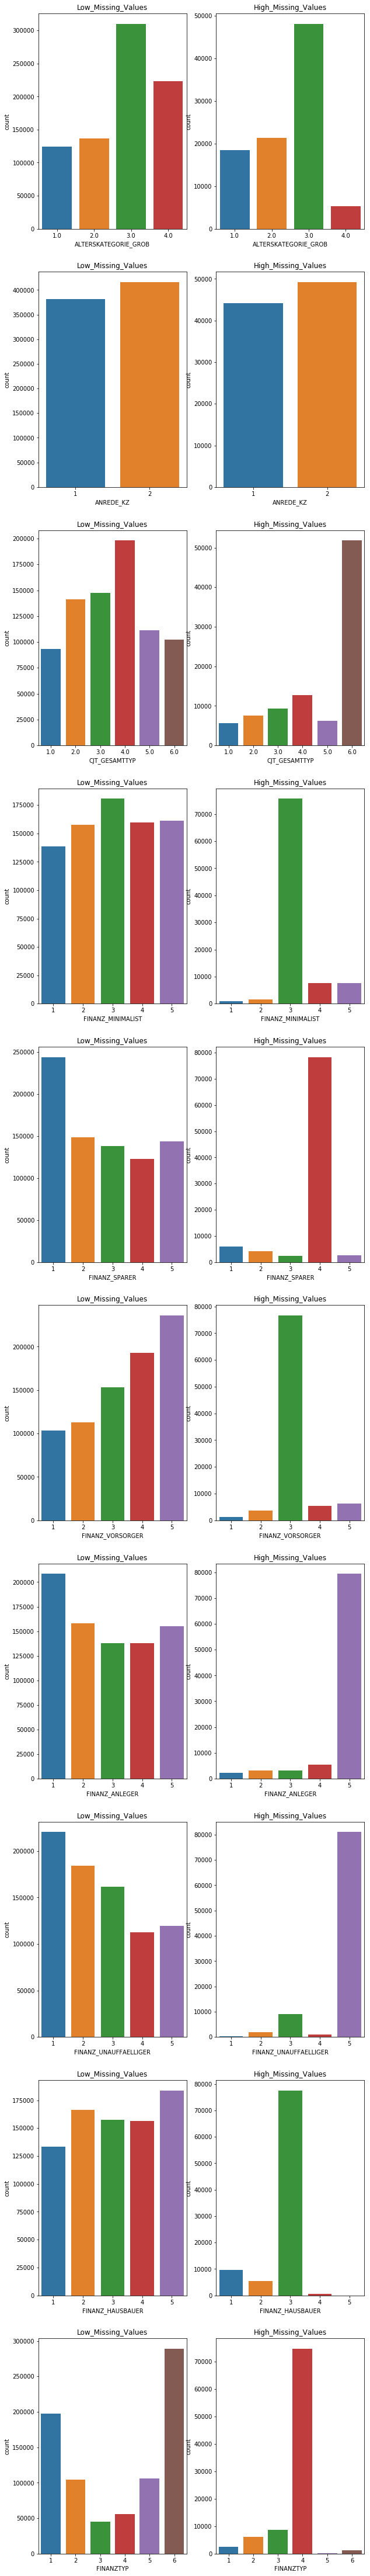

In [252]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
n=0

fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(10, 80))
for i in azdias.columns[0:10]:
    sns.countplot(range_low[i], ax = axs[n,0])
    axs[n,0].set_title('Low_Missing_Values')
    sns.countplot(range_high[i], ax = axs[n,1])
    axs[n,1].set_title('High_Missing_Values')
    n+=1


#### Discussion 1.1.3: Assess Missing Data in Each Row
As we can see that row with missing value between 0 and 25 are 344786 (38 %) and row with missing value in between 25 and 50 are 93281 (10.4 %). Maximum rows have missing values between  0 and 10.
* When we separate rows with missing values less than and greater than 25 per row we find most of the distributions to be significantly different. So it would be safe to say that data with lots of missing values are qualitatively different overall from the data with few or no missing values.  K-means clustering needs no missing information to work and the dataset is made of ordinal, categorical data, where replacing values with means, modes or medians can impact the quality of dataset much more than if the dataset was made up of numerical data. It is thus more appropriate to not consider the missing data and maintain the dataset quality.
* We can see that the distribution of people with more than 25 null values per row have FINANZTYP >=4. This means that they are from a high earning background. To hide their details their values have been not recorded. So we will need more exploration to find out about them. For the scope of the project I have dropped these values. 


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [253]:
# How many features are there of each data type?

feat_info.groupby(['type'])['attribute'].count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [254]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cati = []
cati = (feat_info[feat_info['type'] == 'categorical']['attribute'])
print(cati)

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object


In [255]:
cati12 = [x for x in cati if x in range_low.columns]
cat_binary = [x for x in cati12 if range_low[x].nunique() == 2]
cat_multi = [x for x in cati12 if range_low[x].nunique() > 2]
dict = {'W': 0, 'O': 1}
range_low['OST_WEST_KZ'] = range_low['OST_WEST_KZ'].map(dict)
print(1)



1


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [256]:
cat_multi

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [257]:
cat_multi.remove('CAMEO_DEU_2015')

In [258]:
range_low.drop('CAMEO_DEU_2015', axis = 1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [259]:
range_low = pd.get_dummies(range_low, columns = cat_multi, drop_first = True)

In [260]:
range_low.shape

(797879, 139)

#### Discussion 1.2.1: Re-Encode Categorical Features

* First, I separated binary features (two-level) categoricals and categorical features (three or more levels). I found OST_WEST_KZ to have non numeric values. I mapped a dictionary and converted the features to numeric values. 
* All the categorical features were pesonal -level and were not in much detail so I one hot encoded them with get_dummmies.
* The two features CAMEO_DEUG_2015 and CAMEO_DEU_2015 were related to wealth/life. The first one was a more rough measurement whereas the second one was more detailed. I felt that for inital customer segmentation the first feature CAMEO_DEUG_2015 which has a rough scale is more essential as the scond feature CAMEO_DEU_2015 will be more useful when we identify the inital customer segments and then want to further analyze them. 


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [261]:
def decade(x):
    if x in (1,2):
        return 1
    if x in (3,4,5):
        return 2
    if x in (6,7):
        return 3
    if x in (8,9):
        return 4
    if x in (10,11):
        return 5
    if x in (12,13):
        return 6
    if x in (14,15):
        return 7
    
def movemnt(x):
    b1 = [1,3,5,7,9,11,13,15]
    b2 = [2,4,6,8,10,12,14]
    if x in b1:
        return 0
    if x in b2:
        return 1
    else:
        return x

In [262]:
range_low['RURAL'] = range_low['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})

In [263]:
range_low['GEGEND'] = range_low['WOHNLAGE'].map({0:0,1:1,2:2,3:3,4:4,5:5,7:0,8:0})

In [264]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
range_low['decade'] = range_low['PRAEGENDE_JUGENDJAHRE'].apply(decade)
range_low['movement'] = range_low['PRAEGENDE_JUGENDJAHRE'].apply(movemnt)
range_low.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace=True)

In [265]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
range_low['wealth'] = pd.to_numeric(range_low['CAMEO_INTL_2015']) // 10
range_low['life_stage'] = pd.to_numeric(range_low['CAMEO_INTL_2015']) % 10 
range_low.drop('CAMEO_INTL_2015', axis = 1, inplace = True)

In [266]:
mix = feat_info[feat_info['type'] == 'mixed']['attribute']
mix_feat = [x for x in mix if x in range_low.columns]
range_low.drop(mix_feat, axis = 1, inplace = True)
range_low.drop('MIN_GEBAEUDEJAHR', axis = 1, inplace = True)

In [267]:
range_low.shape

(797879, 138)

#### Discussion 1.2.2: Engineer Mixed-Type Features

* The two features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 were engineered into two new variables 'decade' and 'movement' for PRAEGENDE_JUGENDJAHRE and 'wealth' and 'life stage' for CAMEO_INTL_2015 as specified above.
* The feature CAMEO_INTL_2015 was similar to CAMEO_DEUG_2015 and therefore was and its information was encoded to two new variables so it was dropped, as PRAEGENDE_JUGENDJAHRE.
* The other mixed features like LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB the information was already present in other features like ALTERSKATEGORIE_GROB and LP_FAMILIE_FEIN. So these mixed features were dropped.
* The feaure WOHNLAGE was important as it reflected the quality of the neighborhood. This would be important in clustering. I re-engineered the feature into features -
* RURAL - This tells us whether the neighborhood is rural or not.
* GEGEND - This gives rating to the nighborhood based on quality.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [268]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
for i in range_low.columns:
    print(i, range_low[i].dtype)


ALTERSKATEGORIE_GROB float64
ANREDE_KZ int64
FINANZ_MINIMALIST int64
FINANZ_SPARER int64
FINANZ_VORSORGER int64
FINANZ_ANLEGER int64
FINANZ_UNAUFFAELLIGER int64
FINANZ_HAUSBAUER int64
GREEN_AVANTGARDE int64
HEALTH_TYP float64
RETOURTYP_BK_S float64
SEMIO_SOZ int64
SEMIO_FAM int64
SEMIO_REL int64
SEMIO_MAT int64
SEMIO_VERT int64
SEMIO_LUST int64
SEMIO_ERL int64
SEMIO_KULT int64
SEMIO_RAT int64
SEMIO_KRIT int64
SEMIO_DOM int64
SEMIO_KAEM int64
SEMIO_PFLICHT int64
SEMIO_TRADV int64
SOHO_KZ float64
VERS_TYP float64
ALTER_HH float64
ANZ_PERSONEN float64
ANZ_TITEL float64
HH_EINKOMMEN_SCORE float64
W_KEIT_KIND_HH float64
WOHNDAUER_2008 float64
ANZ_HAUSHALTE_AKTIV float64
ANZ_HH_TITEL float64
KONSUMNAEHE float64
OST_WEST_KZ int64
KBA05_ANTG1 float64
KBA05_ANTG2 float64
KBA05_ANTG3 float64
KBA05_ANTG4 float64
KBA05_GBZ float64
BALLRAUM float64
EWDICHTE float64
INNENSTADT float64
GEBAEUDETYP_RASTER float64
KKK float64
MOBI_REGIO float64
ONLINE_AFFINITAET float64
REGIOTYP float64
KBA13_ANZAHL_PK

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [269]:
def stage_life(x):
    if x % 10 == 1:
        return 1
    if x % 10 == 2:
        return 2
    if x % 10 == 3:
        return 3
    if x % 10 == 4:
        return 4
    if x % 10 == 5:
        return 5
    else: 
        return ''

def welth(x):
    if x // 10 == 1:
        return 1
    if x // 10 == 2:
        return 2
    if x // 10 == 3:
        return 3
    if x // 10 == 4:
        return 4
    if x // 10 == 5:
        return 5
    else:
        return ''
        

In [270]:
def clean_data(cuzdias):
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter =';')
    
    for abcd in range(len(feat_info)):
        feat_info['missing_or_unknown'][abcd] = feat_info['missing_or_unknown'][abcd].strip('[]').split(',')
    for abcd in feat_info.index:
        for abc in range(len(feat_info['missing_or_unknown'][abcd])):
            try:
                feat_info['missing_or_unknown'][abcd][abc] =  int(feat_info['missing_or_unknown'][abcd][abc])
            except:
                continue
        cuzdias.loc[:, feat_info.loc[abcd,'attribute']].replace(feat_info.loc[abcd,'missing_or_unknown'], np.nan, inplace=True)
        
    cuzdias.drop(cols, axis = 1, inplace = True)
    
    cuz_low = cuzdias[cuzdias.isnull().sum(axis = 1) < 25]
    cati = []
    cati = (feat_info[feat_info['type'] == 'categorical']['attribute'])
    cat3 = [x for x in cati if x in cuz_low.columns]
    cat_binary1 = [x for x in cat3 if cuz_low[x].nunique() == 2]
    cat_multi1 = [x for x in cat3 if cuz_low[x].nunique() > 2]
    dict1 = {'W': 0, 'O': 1}
    cuz_low['OST_WEST_KZ'] = cuz_low['OST_WEST_KZ'].map(dict1)
    cat_multi1.remove('CAMEO_DEU_2015')
    cuz_low.drop('CAMEO_DEU_2015', axis = 1, inplace=True)
    cuz_low = pd.get_dummies(cuz_low, columns = cat_multi1, drop_first = True)
    
    cuz_low['decade'] = cuz_low['PRAEGENDE_JUGENDJAHRE'].apply(decade)
    cuz_low['movement'] = cuz_low['PRAEGENDE_JUGENDJAHRE'].apply(movemnt)
    cuz_low.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace=True)
        
    cuz_low['CAMEO_INTL_2015'] = cuz_low['CAMEO_INTL_2015'].str.replace('XX', '')
    cuz_low['CAMEO_INTL_2015'] = pd.to_numeric(cuz_low['CAMEO_INTL_2015'])
        
    cuz_low['wealth'] = pd.to_numeric(cuz_low['CAMEO_INTL_2015']) // 10
    cuz_low['life_stage'] = pd.to_numeric(cuz_low['CAMEO_INTL_2015']) % 10 
    cuz_low.drop('CAMEO_INTL_2015', axis = 1, inplace = True)    
    cuz_low['RURAL'] = cuz_low['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})
    cuz_low['GEGEND'] = cuz_low['WOHNLAGE'].map({0:0,1:1,2:2,3:3,4:4,5:5,7:0,8:0})
    
    mix1 = feat_info[feat_info['type'] == 'mixed']['attribute']
    mix_feat1 = [x for x in mix1 if x in cuz_low.columns]
    cuz_low.drop(mix_feat1, axis = 1, inplace = True)
    cuz_low.drop('MIN_GEBAEUDEJAHR', axis = 1, inplace = True)
    missing123 = [i for i in range_low.columns if i not in cuz_low.columns]
    
    for i in missing123:
        cuz_low[i] = 0
    
    return cuz_low
                    
                    
        
    
    
    
   


   
    
    

In [271]:
#test the clean_data function on demographic dataset
azdias12 = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter =';')
azdias12 = clean_data(azdias12)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [272]:
azdias12.shape

(797879, 138)

In [273]:
cust = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter =';')
cust1 = clean_data(cust) 
cust1.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(141698, 138)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [274]:
cust1.isnull().sum()

ALTERSKATEGORIE_GROB       233
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
HEALTH_TYP                2334
RETOURTYP_BK_S            3108
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KAEM                   0
SEMIO_PFLICHT                0
SEMIO_TRADV                  0
SOHO_KZ                      0
VERS_TYP                  2334
ALTER_HH                 21595
ANZ_PERSONEN                 0
ANZ_TITEL                    0
                         ...  
NATIONALITAET_KZ_2.0         0
NATIONAL

In [275]:
cust1.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,decade,movement,wealth,life_stage,GEBAEUDETYP_5.0,RURAL,GEGEND
count,141465.000000,141698.000000,141698.000000,141698.000000,141698.000000,141698.000000,141698.000000,141698.000000,141698.000000,139364.000000,...,141698.000000,141698.000000,141698.000000,140398.000000,140398.000000,141080.000000,141080.000000,141698.0,141698.0,141698.0
mean,3.487103,1.330717,4.263744,1.431347,4.563099,1.602224,1.865771,2.728387,0.496584,1.962243,...,0.074504,0.092083,0.045103,2.817775,0.515677,2.598760,3.368231,0.0,0.0,0.0
std,0.730129,0.470473,1.018053,0.834332,0.846290,1.002540,0.978548,1.316688,0.499990,0.772795,...,0.262589,0.289144,0.207531,1.503654,0.499756,1.404799,1.340246,0.0,0.0,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.0,0.0
25%,3.000000,1.000000,4.000000,1.000000,4.000000,1.000000,1.000000,2.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,2.000000,0.0,0.0,0.0
50%,4.000000,1.000000,5.000000,1.000000,5.000000,1.000000,2.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,4.000000,0.0,0.0,0.0
75%,4.000000,2.000000,5.000000,2.000000,5.000000,2.000000,2.000000,4.000000,1.000000,3.000000,...,0.000000,0.000000,0.000000,4.000000,1.000000,4.000000,4.000000,0.0,0.0,0.0
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,7.000000,1.000000,5.000000,5.000000,0.0,0.0,0.0


In [276]:
for i in cust1.columns:
    print(i,'-',cust1[i].dtype)

ALTERSKATEGORIE_GROB - float64
ANREDE_KZ - int64
FINANZ_MINIMALIST - int64
FINANZ_SPARER - int64
FINANZ_VORSORGER - int64
FINANZ_ANLEGER - int64
FINANZ_UNAUFFAELLIGER - int64
FINANZ_HAUSBAUER - int64
GREEN_AVANTGARDE - int64
HEALTH_TYP - float64
RETOURTYP_BK_S - float64
SEMIO_SOZ - int64
SEMIO_FAM - int64
SEMIO_REL - int64
SEMIO_MAT - int64
SEMIO_VERT - int64
SEMIO_LUST - int64
SEMIO_ERL - int64
SEMIO_KULT - int64
SEMIO_RAT - int64
SEMIO_KRIT - int64
SEMIO_DOM - int64
SEMIO_KAEM - int64
SEMIO_PFLICHT - int64
SEMIO_TRADV - int64
SOHO_KZ - float64
VERS_TYP - float64
ALTER_HH - float64
ANZ_PERSONEN - float64
ANZ_TITEL - float64
HH_EINKOMMEN_SCORE - float64
W_KEIT_KIND_HH - float64
WOHNDAUER_2008 - float64
ANZ_HAUSHALTE_AKTIV - float64
ANZ_HH_TITEL - float64
KONSUMNAEHE - float64
OST_WEST_KZ - int64
KBA05_ANTG1 - float64
KBA05_ANTG2 - float64
KBA05_ANTG3 - float64
KBA05_ANTG4 - float64
KBA05_GBZ - float64
BALLRAUM - float64
EWDICHTE - float64
INNENSTADT - float64
GEBAEUDETYP_RASTER - float

In [277]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 1)
range_low = pd.DataFrame(imp.fit_transform(range_low), columns = range_low.columns)

In [278]:
range_low.isnull().values.any()

False

In [279]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
range_low = pd.DataFrame(scaler.fit_transform(range_low), columns = range_low.columns)


In [280]:
range_low.head(15)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,RURAL,GEGEND,decade,movement,wealth,life_stage
0,-1.733586,0.957941,-1.494596,1.537980,-1.040675,1.466069,0.958915,1.339175,-0.530446,1.037334,...,-0.391139,-0.329009,2.221478,-0.396036,-0.552802,0.977276,1.240930,0.796073,1.185990,-1.233967
1,0.208166,0.957941,-1.494596,0.864618,-1.766937,-0.570947,0.244343,1.339175,1.885206,1.037334,...,-0.391139,-0.329009,-0.450151,-0.396036,-0.552802,-0.238883,1.240930,-1.256166,-0.832476,0.765885
2,1.179043,0.957941,0.683183,-0.482105,1.138111,-0.570947,-1.184799,-0.791460,-0.530446,-0.112747,...,-0.391139,-0.329009,-0.450151,-0.396036,1.808965,-1.455042,-0.185757,0.796073,-1.505298,-0.567350
3,0.208166,-1.043906,0.683183,0.191257,0.411849,-1.249952,0.244343,-0.791460,-0.530446,1.037334,...,2.556639,-0.329009,-0.450151,-0.396036,-0.552802,0.369197,-0.185757,0.796073,0.513168,0.099267
4,-1.733586,0.957941,-0.042743,-1.155466,1.138111,-0.570947,-0.470228,1.339175,-0.530446,1.037334,...,-0.391139,-0.329009,2.221478,-0.396036,1.808965,-1.455042,-1.136881,-1.256166,1.185990,0.765885
5,-0.762710,0.957941,-1.494596,1.537980,-1.766937,1.466069,0.958915,-0.081249,-0.530446,-0.112747,...,-0.391139,-0.329009,-0.450151,-0.396036,-0.552802,1.585356,0.289806,0.796073,-0.832476,-0.567350
6,-1.733586,-1.043906,-0.042743,0.191257,0.411849,-1.249952,0.244343,-0.791460,-0.530446,-1.262827,...,-0.391139,-0.329009,-0.450151,-0.396036,-0.552802,-0.846962,-0.185757,0.796073,-1.505298,0.765885
7,0.208166,-1.043906,0.683183,0.864618,-1.040675,0.787063,-0.470228,-0.791460,1.885206,1.037334,...,-0.391139,-0.329009,-0.450151,-0.396036,-0.552802,-0.846962,0.289806,-1.256166,-1.505298,0.099267
8,0.208166,0.957941,-0.768669,0.864618,-1.040675,0.108058,1.673486,0.628963,1.885206,-0.112747,...,-0.391139,-0.329009,-0.450151,-0.396036,1.808965,-1.455042,1.240930,-1.256166,-1.505298,1.432502
9,0.208166,0.957941,-0.768669,-0.482105,1.138111,0.108058,-1.184799,1.339175,-0.530446,-0.112747,...,-0.391139,-0.329009,-0.450151,2.525025,-0.552802,1.585356,-1.136881,-1.256166,1.185990,-1.233967


In [281]:
range_low.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,RURAL,GEGEND,decade,movement,wealth,life_stage
count,7.978790e+05,7.978790e+05,7.978790e+05,7.978790e+05,7.978790e+05,7.978790e+05,7.978790e+05,7.978790e+05,7.978790e+05,7.978790e+05,...,7.978790e+05,7.978790e+05,7.978790e+05,7.978790e+05,7.978790e+05,7.978790e+05,7.978790e+05,7.978790e+05,7.978790e+05,7.978790e+05
mean,-1.829168e-17,-2.025176e-16,-7.595411e-17,1.018866e-16,-1.321828e-16,-1.269731e-16,8.555413e-17,1.091801e-16,3.722455e-18,1.056981e-16,...,9.030070e-18,-3.477557e-17,-2.429392e-17,5.371734e-17,8.273112e-18,-9.324839e-17,-1.895068e-16,7.531292e-17,-8.540273e-17,-5.996893e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.704462e+00,-1.043906e+00,-1.494596e+00,-1.155466e+00,-1.766937e+00,-1.249952e+00,-1.184799e+00,-1.501672e+00,-5.304461e-01,-2.412907e+00,...,-3.911385e-01,-3.290089e-01,-4.501507e-01,-3.960358e-01,-5.528024e-01,-1.455042e+00,-2.088006e+00,-1.256166e+00,-2.178120e+00,-1.900584e+00
25%,-7.627096e-01,-1.043906e+00,-7.686694e-01,-1.155466e+00,-1.040675e+00,-1.249952e+00,-1.184799e+00,-7.914605e-01,-5.304461e-01,-1.127466e-01,...,-3.911385e-01,-3.290089e-01,-4.501507e-01,-3.960358e-01,-5.528024e-01,-8.469623e-01,-1.136881e+00,-1.256166e+00,-8.324761e-01,-1.233967e+00
50%,2.081665e-01,9.579411e-01,-4.274333e-02,1.912569e-01,4.118494e-01,1.080582e-01,-4.702278e-01,-8.124879e-02,-5.304461e-01,-1.127466e-01,...,-3.911385e-01,-3.290089e-01,-4.501507e-01,-3.960358e-01,-5.528024e-01,3.691969e-01,-1.857567e-01,7.960732e-01,5.131678e-01,9.926748e-02
75%,1.179043e+00,9.579411e-01,6.831828e-01,8.646185e-01,1.138111e+00,7.870634e-01,9.589146e-01,6.289629e-01,-5.304461e-01,1.037334e+00,...,-3.911385e-01,-3.290089e-01,-4.501507e-01,-3.960358e-01,-5.528024e-01,9.772765e-01,1.240930e+00,7.960732e-01,1.185990e+00,7.658845e-01
max,1.179043e+00,9.579411e-01,1.409109e+00,1.537980e+00,1.138111e+00,1.466069e+00,1.673486e+00,1.339175e+00,1.885206e+00,1.037334e+00,...,2.556639e+00,3.039431e+00,2.221478e+00,2.525025e+00,1.808965e+00,1.585356e+00,1.240930e+00,7.960732e-01,1.185990e+00,1.432502e+00


### Discussion 2.1: Apply Feature Scaling

**I used mode as the strategy in imputer to replace the missing values in the dataset** 
* As most of the features are categorical or ordinal in nature taking a mean, median would result in a dataset whose distrubution have been centered. 
By taking the most frequent value it would ensure approriate clustering.
* For scaling I used standard scalar.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [152]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA(100)
range_low_pca = pca.fit_transform(range_low)

In [282]:
from sklearn.decomposition import PCA

In [61]:
from sklearn.decomposition import PCA

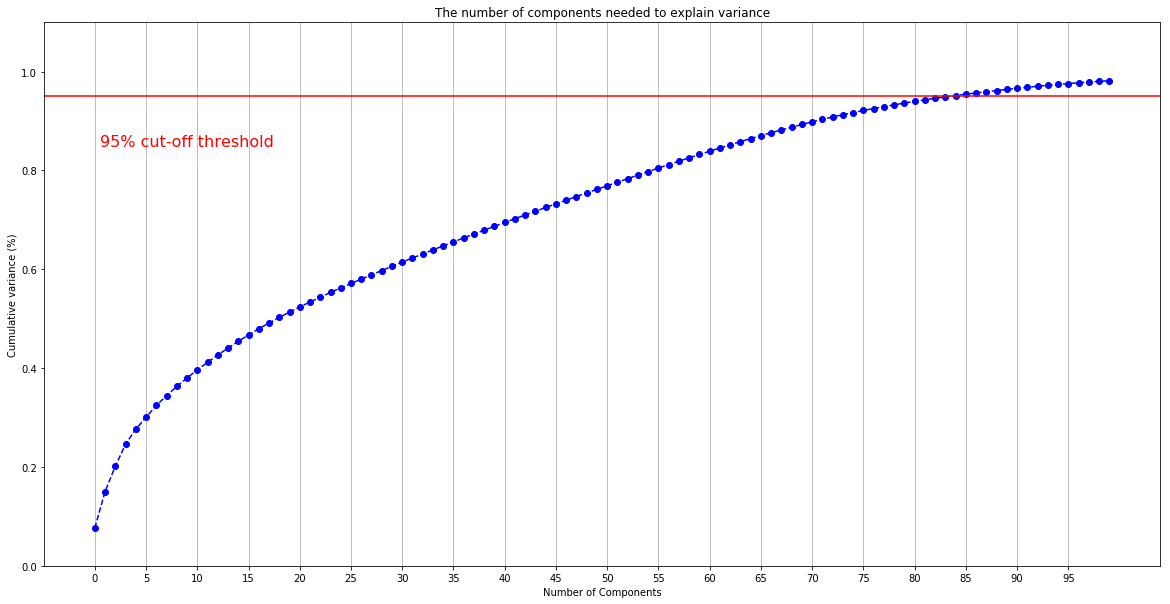

In [155]:
# Investigate the variance accounted for by each principal component.
plt.rcParams["figure.figsize"] = (20,10)

fig, ax = plt.subplots()
xi = np.arange(0, 100, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 100, step=5)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()


In [283]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(85)
range_low_pca1 = pca.fit_transform(range_low)

### Discussion 2.2: Perform Dimensionality Reduction

By taking the cumulative sum of the variance captured by each principle component and ploting the results using a scree plot we can see that about 60% variance is captured by 30 principle components, but to get accurate clustering results I decided to keep 95 % of the information of the originasl dataset and selected 85 principle components which capture 95% variance in the data. It is amazing how we were able to capture 95 % variance by reducing our dataset columns by almost half.  

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [284]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
range_low1_len = len(range_low.columns)
f_map = pd.Series(range_low.columns, range(range_low1_len))
def feature_pca(i):
    dict2 = {}
    print('Component: ', i)
    dict2 = [(f_map[a],b) for a,b in enumerate(pca.components_[i])]
    dict2 = pd.DataFrame(dict2, columns = ['Feature', 'Value'])
    dict3 = dict2.sort_values(by = ['Value'], ascending = False)
    dict3.reset_index(drop=True, inplace=True)
    return dict3
    
    

      

In [357]:
feature_1 = feature_pca(0)
print(feature_1[:5])

Component:  0
              Feature     Value
0          PLZ8_ANTG3  0.186033
1          PLZ8_ANTG4  0.183642
2  HH_EINKOMMEN_SCORE  0.182162
3              wealth  0.181393
4         ORTSGR_KLS9  0.172451


In [358]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
feature_2 = feature_pca(1)
print(feature_2[:5])

Component:  1
                Feature     Value
0  ALTERSKATEGORIE_GROB  0.215567
1      FINANZ_VORSORGER  0.206278
2            ZABEOTYP_3  0.200116
3             SEMIO_ERL  0.175762
4            SEMIO_LUST  0.157717


In [364]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
feature_3 = feature_pca(2)
print(feature_3[:5])

Component:  2
             Feature     Value
0         SEMIO_VERT  0.333670
1          SEMIO_FAM  0.264274
2          SEMIO_SOZ  0.262278
3         SEMIO_KULT  0.255279
4  FINANZ_MINIMALIST  0.142932


In [289]:
dict_comp = {}
for i in range(len(pca.components_)):
    dict_comp[i] = [(f_map[a],b) for a,b in sorted(enumerate(pca.components_[i]),key=lambda x:x[1], reverse=True)]

pd.DataFrame(dict_comp)

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
0,"(PLZ8_ANTG3, 0.186033094737)","(ALTERSKATEGORIE_GROB, 0.215567240806)","(SEMIO_VERT, 0.333670021639)","(GREEN_AVANTGARDE, 0.31981599651)","(LP_STATUS_GROB_4.0, 0.262216693681)","(GEBAEUDETYP_3.0, 0.131706602545)","(LP_STATUS_GROB_3.0, 0.345963232893)","(PLZ8_HHZ, 0.303217579861)","(LP_STATUS_GROB_3.0, 0.258485670415)","(KBA13_ANZAHL_PKW, 0.244689877995)",...,"(RETOURTYP_BK_S, 0.591920948211)","(KONSUMNAEHE, 0.271463843336)","(KBA13_ANZAHL_PKW, 0.28265684747)","(ANZ_TITEL, 0.587052150448)","(ALTER_HH, 0.424058027179)","(ANZ_TITEL, 0.199962500488)","(KONSUMNAEHE, 0.407673864542)","(W_KEIT_KIND_HH, 0.383532777274)","(SEMIO_KRIT, 0.326691835035)","(SEMIO_LUST, 0.36706215411)"
1,"(PLZ8_ANTG4, 0.183641770922)","(FINANZ_VORSORGER, 0.206277678794)","(SEMIO_FAM, 0.264274279255)","(LP_STATUS_FEIN_10.0, 0.297480437457)","(LP_STATUS_FEIN_9.0, 0.240326992765)","(LP_STATUS_GROB_2.0, 0.116277381902)","(LP_FAMILIE_GROB_5.0, 0.320091251315)","(KBA13_ANZAHL_PKW, 0.26727290742)","(LP_FAMILIE_FEIN_2.0, 0.210506690861)","(PLZ8_HHZ, 0.228050878067)",...,"(ZABEOTYP_5, 0.366629810933)","(LP_STATUS_FEIN_5.0, 0.201827347867)","(HEALTH_TYP, 0.256064868119)","(KONSUMNAEHE, 0.176265631768)","(SEMIO_SOZ, 0.405153588311)","(VERS_TYP, 0.178172597318)","(VERS_TYP, 0.315027853998)","(ANZ_TITEL, 0.204063528634)","(SEMIO_SOZ, 0.31137606815)","(HEALTH_TYP, 0.302074045606)"
2,"(HH_EINKOMMEN_SCORE, 0.182162315742)","(ZABEOTYP_3, 0.200116183226)","(SEMIO_SOZ, 0.262278176999)","(LP_STATUS_GROB_5.0, 0.297480437457)","(FINANZTYP_3, 0.150974755087)","(LP_STATUS_FEIN_3.0, 0.109610742265)","(LP_STATUS_FEIN_6.0, 0.294623266282)","(PLZ8_GBZ, 0.255765711241)","(LP_FAMILIE_GROB_2.0, 0.210506690861)","(PLZ8_GBZ, 0.179301567364)",...,"(BALLRAUM, 0.176613065425)","(GEBAEUDETYP_3.0, 0.188436660281)","(SEMIO_MAT, 0.118376151521)","(VERS_TYP, 0.168223199783)","(SEMIO_KRIT, 0.287729384332)","(FINANZTYP_3, 0.173967311717)","(GEBAEUDETYP_3.0, 0.204482809292)","(KONSUMNAEHE, 0.183469527074)","(ZABEOTYP_5, 0.310124956651)","(SEMIO_PFLICHT, 0.181088691472)"
3,"(wealth, 0.181392740199)","(SEMIO_ERL, 0.175761709326)","(SEMIO_KULT, 0.255279350862)","(ORTSGR_KLS9, 0.219377345349)","(FINANZTYP_6, 0.147556055799)","(SEMIO_MAT, 0.107744803671)","(ANZ_PERSONEN, 0.252084152556)","(LP_STATUS_GROB_3.0, 0.251674416683)","(LP_STATUS_FEIN_6.0, 0.206360640215)","(LP_STATUS_GROB_4.0, 0.160221540656)",...,"(WOHNDAUER_2008, 0.161239470333)","(PLZ8_ANTG2, 0.18569672662)","(KKK, 0.116367386485)","(LP_STATUS_FEIN_6.0, 0.167663474125)","(SEMIO_LUST, 0.251414780262)","(life_stage, 0.163319619862)","(SEMIO_LUST, 0.191954281974)","(KBA05_GBZ, 0.177350704674)","(life_stage, 0.225921490459)","(SEMIO_FAM, 0.141049621536)"
4,"(ORTSGR_KLS9, 0.172451123059)","(SEMIO_LUST, 0.157716852589)","(FINANZ_MINIMALIST, 0.142931733298)","(EWDICHTE, 0.21549440166)","(LP_FAMILIE_GROB_4.0, 0.146617253134)","(LP_FAMILIE_FEIN_2.0, 0.104942056974)","(GEBAEUDETYP_3.0, 0.243590235137)","(HEALTH_TYP, 0.236655299528)","(W_KEIT_KIND_HH, 0.194818810451)","(LP_STATUS_FEIN_9.0, 0.155608454673)",...,"(ZABEOTYP_4, 0.153393319256)","(PLZ8_ANTG1, 0.15108320923)","(PLZ8_ANTG4, 0.106110288384)","(PLZ8_ANTG2, 0.156314499147)","(SEMIO_PFLICHT, 0.222074763811)","(GEBAEUDETYP_RASTER, 0.154254856233)","(SEMIO_PFLICHT, 0.172955098426)","(RETOURTYP_BK_S, 0.156025907931)","(LP_FAMILIE_FEIN_11.0, 0.138618940809)","(SEMIO_REL, 0.140299010185)"
5,"(EWDICHTE, 0.170380084666)","(RETOURTYP_BK_S, 0.153744876593)","(FINANZTYP_5, 0.137172346991)","(ANZ_PERSONEN, 0.151276234818)","(OST_WEST_KZ, 0.131159999543)","(LP_FAMILIE_GROB_2.0, 0.104942056974)","(LP_FAMILIE_FEIN_10.0, 0.23165380053)","(LP_STATUS_FEIN_6.0, 0.217788578905)","(LP_STATUS_FEIN_7.0, 0.155135979254)","(LP_STATUS_FEIN_2.0, 0.144316026554)",...,"(LP_STATUS_FEIN_8.0, 0.122597250439)","(ANZ_TITEL, 0.141462923769)","(ANZ_TITEL, 0.105399182099)","(GEBAEUDETYP_3.0, 0.111327559476)","(HEALTH_TYP, 0.209766778985)","(HH_EINKOMMEN_SCORE, 0.13431845152)",

### Discussion 2.3: Interpret Principal Components

The principal components are a linear combination of the the 136 features to get a reduced feature set. The magnitude of weight assigned to each feature is propotional to its importance in the principal component.
We can see that the first principal component attributes to approximately 10% of the total variance and the first 3 components account for 20 % of the variance.

The first component has 

* "PLZ8_ANTG3" - Number of 6-10 family houses in the PLZ8 region, "PLZ8_ANTG4" - Number of 10+ family houses in the PLZ8 region, "HH_EINKOMMEN_SCORE" - Estimated household net income, "wealth" - wealth of the population density in the region, and "ORTSGR_KLS9" - size of the community
* The First Principal Component gives us the information about the population density in the region and the wealth of the population living in that region.


The second component has

* "ALTERSKATEGORIE_GROB" - Estimated age based on given name analysis, "FINANZ_VORSORGER" - Financial typology of people prepared, "ZABEOTYP_3" - fairly supplied energy consumption typology, "SEMIO_ERL" - Personality typology od people who are event oriented, "SEMIO_LUST" - Personality typology of people who are sensual-minded.
* The second principal component tells us the estimation of age of the people who are event driven and sensual minded and are financially prepared. 

The third component has 

* "SEMIO_VERT" - Personality typology of people who are dreamful, "SEMIO_FAM" -  Personality typology of people who are family-minded, "SEMIO_SOZ" - Personality typology of people who are socially-minded, "SEMIO_KULT" - Personality typology of people who are cultural-minded, and "FINANZ_MINIMALIST" - Financial typology of people with low financial interest.
* The third component tells us the topology of family minded, socially minded, culturally minded, dreamful people who have low financial interest.




## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [290]:
from sklearn.cluster import KMeans

In [63]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
def kmeans_algo(data, clust):
    model = KMeans(n_clusters = clust, max_iter = 30)
    
    model1 = model.fit(data)
    
    score = np.abs(model1.score(data))
    
    return score
    
    
    # run k-means clustering on the data and...
k_score = []
for i in range(1,30,2): 
    k_score.append(kmeans_algo(range_low_pca1, i))
    
    
    # compute the average within-cluster distances.
    
    

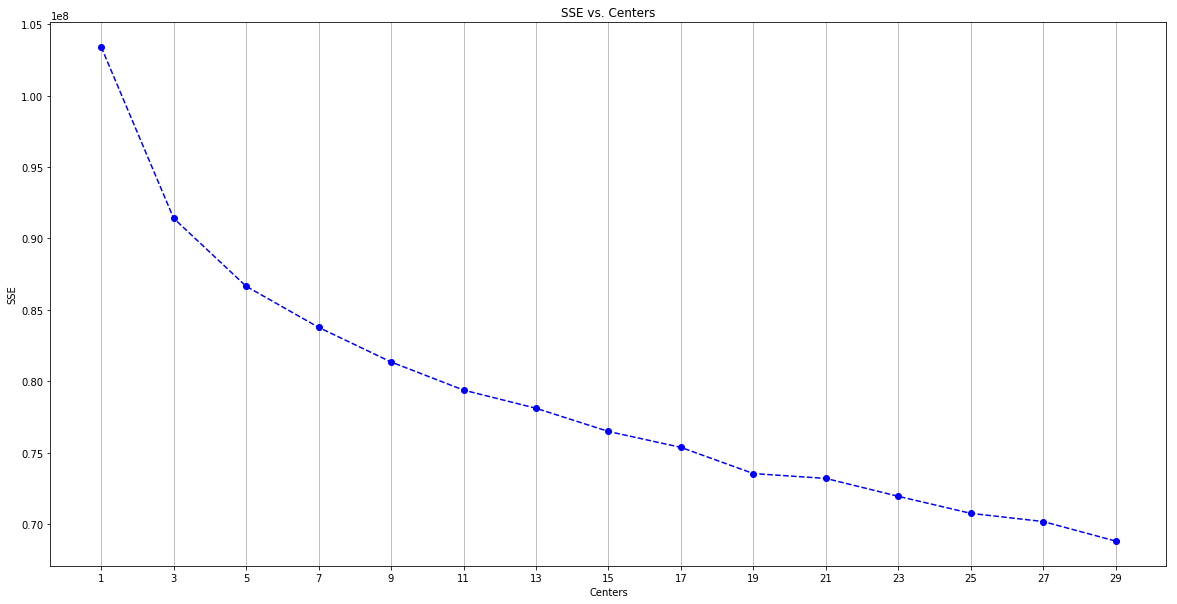

In [64]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
ind = [i for i in range(1,30,2)]
plt.plot(ind, k_score, linestyle='--', marker='o', color='b');
plt.xlabel('Centers');
plt.xticks(np.arange(1, 30, step=2)); 
plt.ylabel('SSE');
plt.title('SSE vs. Centers');
ax.grid(axis='x')
plt.show()

In [291]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 25, max_iter = 30)    
model_kmeans = kmeans.fit(range_low_pca1)
    


In [292]:
azdias_predict = model_kmeans.predict(range_low_pca1)
azdias_clustered = pd.DataFrame(azdias_predict, columns = ['Clustered_Demographic'])

### Discussion 3.1: Apply Clustering to General Population

Implemeted KMeans algorithm and caluclated the score (distance between center and points) for about 15 clusters. Plotted the results using a scree plot. I observed the point where further increasing the number of clusters wont impact the the score mutch. I chose this point (25 clusters) as the ideal number of clusters to apply to our dataset.  

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [293]:
# Load in the customer demographics data.
cust = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter =';')
customers = clean_data(cust) 
customers.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(141698, 138)

In [294]:
customers = pd.DataFrame(imp.transform(customers), columns = customers.columns)

In [295]:
customers = pd.DataFrame(scaler.transform(customers), columns = customers.columns)

In [296]:
customers.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,decade,movement,wealth,life_stage,GEBAEUDETYP_5.0,RURAL,GEGEND
count,1.416980e+05,1.416980e+05,1.416980e+05,1.416980e+05,1.416980e+05,1.416980e+05,1.416980e+05,1.416980e+05,1.416980e+05,1.416980e+05,...,1.416980e+05,1.416980e+05,1.416980e+05,1.416980e+05,1.416980e+05,1.416980e+05,1.416980e+05,141698.0,141698.0,141698.0
mean,-2.181302e-17,2.028861e-16,2.990765e-16,7.050368e-17,4.019111e-16,-3.620459e-17,-6.164058e-17,2.106084e-17,-6.478717e-17,-4.372632e-17,...,4.904168e-17,3.931358e-17,-4.846501e-17,-3.349677e-17,5.551037e-17,-8.100903e-17,-4.859038e-17,0.0,0.0,0.0
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,0.0,0.0,0.0
min,-4.685046e+00,-7.029490e-01,-3.205879e+00,-5.169987e-01,-4.210273e+00,-6.007007e-01,-8.847533e-01,-1.312683e+00,-9.931917e-01,-2.394235e+00,...,-2.837272e-01,-3.184689e-01,-2.173323e-01,-1.836001e+00,-1.022137e+00,-1.832260e+00,-2.473826e+00,0.0,0.0,0.0
25%,-6.478012e-01,-7.029490e-01,-2.590679e-01,-5.169987e-01,-6.653760e-01,-6.007007e-01,-8.847533e-01,-5.531984e-01,-9.931917e-01,-1.153648e+00,...,-2.837272e-01,-3.184689e-01,-2.173323e-01,-5.207782e-01,-1.022137e+00,-1.124120e+00,-9.984741e-01,0.0,0.0,0.0
50%,6.979469e-01,-7.029490e-01,7.232024e-01,-5.169987e-01,5.162564e-01,-6.007007e-01,1.371722e-01,-5.531984e-01,-9.931917e-01,8.693862e-02,...,-2.837272e-01,-3.184689e-01,-2.173323e-01,-5.207782e-01,9.783428e-01,-4.159795e-01,4.768774e-01,0.0,0.0,0.0
75%,6.979469e-01,1.422578e+00,7.232024e-01,6.815694e-01,5.162564e-01,3.967691e-01,1.371722e-01,9.657697e-01,1.006855e+00,1.327526e+00,...,-2.837272e-01,-3.184689e-01,-2.173323e-01,7.944449e-01,9.783428e-01,1.000301e+00,4.768774e-01,0.0,0.0,0.0
max,6.979469e-01,1.422578e+00,7.232024e-01,4.277274e+00,5.162564e-01,3.389179e+00,3.202948e+00,1.725254e+00,1.006855e+00,1.327526e+00,...,3.524512e+00,3.140024e+00,4.601249e+00,2.767280e+00,9.783428e-01,1.708441e+00,1.214553e+00,0.0,0.0,0.0


In [297]:
cust_pca = pca.transform(customers)
cust_clustered = model_kmeans.predict(cust_pca)
customers_clustered = pd.DataFrame(cust_clustered, columns = ['Clustered_Customers'])

In [298]:
customers_clustered.isnull().values.any()

False

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [299]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
azdiascluster = azdias_clustered['Clustered_Demographic'].value_counts().sort_index()/len(azdias_clustered)*100
customercluster = customers_clustered['Clustered_Customers'].value_counts().sort_index()/len(customers_clustered)*100
diff = customercluster - azdiascluster

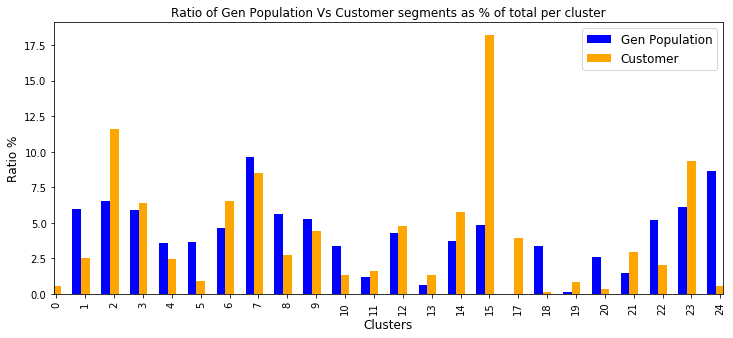

In [300]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111)
ax = azdiascluster.plot(width=-0.3,align='edge',color='blue',kind='bar',position=0)
ax = customercluster.plot(width=-0.3,align='edge',color='orange',kind='bar',position=1)
plt.xlabel('Clusters', fontsize=12) 
plt.ylabel('Ratio %', fontsize=12)
plt.legend(('Gen Population', 'Customer'),fontsize=12)
plt.title(('Ratio of Gen Population Vs Customer segments as % of total per cluster'))
plt.show()


In [301]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
azdiascluster = pd.DataFrame(azdias_clustered['Clustered_Demographic'].value_counts().sort_index()/len(azdias_clustered)*100)
customercluster = pd.DataFrame(customers_clustered['Clustered_Customers'].value_counts().sort_index()/len(customers_clustered)*100)                             
diff = pd.DataFrame(diff, columns = ['Difference'])                             
azdiascluster.join(customercluster).join(diff).sort_values('Difference', ascending = False)                           


,Clustered_Demographic,Clustered_Customers,Difference
15,4.866778,18.183037,13.316259
2,6.534575,11.559796,5.025221
14,3.753201,5.773547,2.020346
6,4.620751,6.549140,1.928389
13,0.613000,1.364875,0.751874
23,8.638152,9.379102,0.740950
17,3.343364,3.918192,0.574828
12,4.274583,4.755184,0.480601
3,5.920572,6.375531,0.454959
11,1.164838,1.610467,0.445629


In [334]:
cluster_specs = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_)), columns=range_low.columns)
cluster_specs

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,RURAL,GEGEND,decade,movement,wealth,life_stage
0,3.399842,1.240837,4.835408,1.456269,4.294000,1.706898,2.185127,1.406545,0.425509,2.034998,...,0.072925,0.067932,-0.011456,2.324198,0.674579,1.974338,3.632251,0.236510,-0.526014,0.023128
1,2.783507,0.797530,3.451149,2.402814,3.694388,2.161230,2.773707,3.085578,0.363286,2.076885,...,0.095336,0.142406,0.120311,3.149195,0.293879,3.288756,4.738917,0.574814,0.610592,-0.388566
2,3.889637,0.916230,5.538771,0.789624,5.144890,1.088974,1.208809,1.706343,0.259456,2.097787,...,0.082311,0.059554,-0.026735,2.236796,0.894317,1.705612,2.532559,-0.228250,-0.570111,0.247793
3,3.881166,1.284147,4.499481,0.809282,5.109772,0.612974,1.399057,3.367704,0.785929,1.873983,...,0.118972,0.124743,0.039213,2.451029,0.244574,2.774564,2.676075,-0.385348,-0.009550,0.201124
4,3.046197,0.831754,3.631718,2.043804,3.943332,1.698280,2.060383,3.069749,0.293378,2.321336,...,-0.001102,0.098225,0.094484,4.697020,0.228748,3.725125,4.293870,0.643886,0.977113,-0.796403
5,2.735593,1.751580,3.372410,2.262673,3.855828,2.949063,2.934006,2.673254,0.503617,1.985443,...,0.055884,0.053257,-0.028200,2.273082,0.848805,1.675730,4.638002,0.207889,-0.649348,0.261007
6,3.991259,1.729263,5.263892,0.686588,5.168248,0.980648,1.327773,1.932368,1.346356,1.833617,...,0.049892,0.033443,-0.029847,2.237808,0.433937,2.329423,2.727382,-0.236814,-0.819301,0.481334
7,4.033610,1.755283,3.821063,0.943513,5.122530,1.134906,1.158424,3.906989,0.236436,1.791938,...,0.085915,0.133954,0.144103,3.318839,0.248675,3.382972,2.320760,-0.305923,0.757941,-0.130259
8,2.771695,1.780651,3.007585,2.337794,3.817227,2.678594,2.751612,3.491971,0.299086,2.110657,...,0.139321,0.136120,0.039053,2.507489,0.401897,2.863475,4.631761,0.683264,0.092492,0.047644
9,4.007232,1.692319,5.179588,0.759308,5.123839,1.436705,1.264609,2.026402,0.245194,1.805597,...,0.076032,0.058343,-0.026567,2.251099,0.875870,1.672907,2.415961,-0.216044,-0.579700,0.263559


In [303]:
#Cluster 15 principal components analysis with over-representation in customer segment
pca_cluster = kmeans.cluster_centers_[15]
pca_cluster1 = pd.Series(pca_cluster)
pc1 = pd.DataFrame(pca_cluster,columns = ['C7_Comp'])
pc1 = pc1.sort_values(by = ['C7_Comp'], ascending = False)
pc1[:3]

,C7_Comp
2,3.068775
3,2.791859
12,1.397158


In [335]:
#Cluster 15 - finding important features and viewing the cluster centers transformed to original feature values 
feat_pca1 = feature_pca(2)
feat_4 = []
feat_4 = feat_pca1['Feature'][:10]
cluster_specs.loc[14,feat_4]

Component:  2


SEMIO_VERT           5.617610
SEMIO_FAM            4.245354
SEMIO_SOZ            4.557853
SEMIO_KULT           4.317807
FINANZ_MINIMALIST    5.040384
FINANZTYP_5          0.148789
SEMIO_REL            3.566638
SEMIO_MAT            4.033837
RETOURTYP_BK_S       3.222533
W_KEIT_KIND_HH       2.499472
Name: 14, dtype: float64

In [307]:
#Cluster 2 principal components analysis with over-representation in customer segment
pca_cluster = kmeans.cluster_centers_[2]
pca_cluster1 = pd.Series(pca_cluster)
pc1 = pd.DataFrame(pca_cluster,columns = ['C7_Comp'])
pc1 = pc1.sort_values(by = ['C7_Comp'], ascending = False)
pc1[:3]

,C7_Comp
2,1.922536
4,1.089765
13,0.662767


In [337]:
#Cluster 2 - finding important features and viewing the cluster centers transformed to original feature values 
feat_pca2 = feature_pca(2)
feat_2 = []
feat_2 = feat_pca2['Feature'][:10]
cluster_specs.loc[14,feat_2]

Component:  2


SEMIO_VERT           5.617610
SEMIO_FAM            4.245354
SEMIO_SOZ            4.557853
SEMIO_KULT           4.317807
FINANZ_MINIMALIST    5.040384
FINANZTYP_5          0.148789
SEMIO_REL            3.566638
SEMIO_MAT            4.033837
RETOURTYP_BK_S       3.222533
W_KEIT_KIND_HH       2.499472
Name: 14, dtype: float64

In [341]:
#Cluster 14 principal components analysis with over-representation in customer segment
pca_cluster = kmeans.cluster_centers_[14]
pca_cluster1 = pd.Series(pca_cluster)
pc1 = pd.DataFrame(pca_cluster,columns = ['C7_Comp'])
pc1 = pc1.sort_values(by = ['C7_Comp'], ascending = False)
pc1[:3]

,C7_Comp
3,3.990353
12,1.060565
14,0.667695


In [342]:
#Cluster 14 - finding important features and viewing the cluster centers transformed to original feature values 
feat_pca1 = feature_pca(3)
feat_1 = []
feat_1 = feat_pca1['Feature'][:10]
cluster_specs.loc[14,feat_1]

Component:  3


GREEN_AVANTGARDE       1.499915
LP_STATUS_GROB_5.0     1.501196
LP_STATUS_FEIN_10.0    1.501196
ORTSGR_KLS9            4.756543
EWDICHTE               3.600989
ANZ_PERSONEN           3.365745
ONLINE_AFFINITAET      4.199587
GEGEND                 2.253219
SEMIO_DOM              4.165022
ZABEOTYP_2             0.256658
Name: 14, dtype: float64

In [343]:
#Cluster 13 principal components analysis with over-representation in customer segment
pca_cluster = kmeans.cluster_centers_[13]
pca_cluster1 = pd.Series(pca_cluster)
pc1 = pd.DataFrame(pca_cluster,columns = ['C7_Comp'])
pc1 = pc1.sort_values(by = ['C7_Comp'], ascending = False)
pc1[:3]

,C7_Comp
55,5.396851
50,3.629939
48,2.888539


In [344]:
#Cluster 13 - finding important features and viewing the cluster centers transformed to original feature values 
feat_pca1 = feature_pca(55)
feat_1 = []
feat_1 = feat_pca1['Feature'][:10]
cluster_specs.loc[13,feat_1]

Component:  55


GEBAEUDETYP_2.0         1.529750
LP_FAMILIE_FEIN_5.0    -0.002487
GEBAEUDETYP_6.0         0.129373
GEBAEUDETYP_4.0        -0.000104
CAMEO_DEUG_2015_5       0.134803
LP_FAMILIE_FEIN_6.0    -0.002593
GFK_URLAUBERTYP_2.0     0.050613
LP_FAMILIE_FEIN_7.0    -0.004801
LP_FAMILIE_FEIN_10.0    0.083486
ZABEOTYP_5             -0.010633
Name: 13, dtype: float64

In [354]:
#Cluster 22 principal components analysis with under-representation in customer segment
pca_cluster = kmeans.cluster_centers_[22]
pca_cluster1 = pd.Series(pca_cluster)
pc1 = pd.DataFrame(pca_cluster,columns = ['C7_Comp'])
pc1 = pc1.sort_values(by = ['C7_Comp'], ascending = False)
pc1[:3]

,C7_Comp
0,5.824415
8,0.913805
3,0.686927


In [355]:
#Cluster 22 - finding important features and viewing the cluster centers transformed to original feature values 
feat_pca1 = feature_pca(0)
feat_1 = []
feat_1 = feat_pca1['Feature'][:10]
cluster_specs.loc[22,feat_1]

Component:  0


PLZ8_ANTG3            2.286288
PLZ8_ANTG4            1.220156
HH_EINKOMMEN_SCORE    4.654808
wealth                0.880170
ORTSGR_KLS9           7.138954
EWDICHTE              5.373873
FINANZ_SPARER         2.362049
GEGEND                3.551727
FINANZ_HAUSBAUER      3.824784
LP_STATUS_FEIN_2.0    0.132998
Name: 22, dtype: float64

In [348]:
#Cluster 1 principal components analysis with under-representation in customer segment
pca_cluster = kmeans.cluster_centers_[1]
pca_cluster1 = pd.Series(pca_cluster)
pc1 = pd.DataFrame(pca_cluster,columns = ['C7_Comp'])
pc1 = pc1.sort_values(by = ['C7_Comp'], ascending = False)
pc1[:3]

,C7_Comp
0,3.997987
2,2.608460
16,0.338253


In [349]:
#Cluster 1 - finding important features and viewing the cluster centers transformed to original feature values 
feat_pca1 = feature_pca(0)
feat_1 = []
feat_1 = feat_pca1['Feature'][:10]
cluster_specs.loc[1,feat_1]

Component:  0


PLZ8_ANTG3            1.868376
PLZ8_ANTG4            0.781416
HH_EINKOMMEN_SCORE    4.318793
wealth                0.610592
ORTSGR_KLS9           5.989848
EWDICHTE              4.516747
FINANZ_SPARER         2.402814
GEGEND                3.288756
FINANZ_HAUSBAUER      3.085578
LP_STATUS_FEIN_2.0    0.084980
Name: 1, dtype: float64

In [351]:
#Cluster 5 principal components analysis with under-representation in customer segment
pca_cluster = kmeans.cluster_centers_[5]
pca_cluster1 = pd.Series(pca_cluster)
pc1 = pd.DataFrame(pca_cluster,columns = ['C7_Comp'])
pc1 = pc1.sort_values(by = ['C7_Comp'], ascending = False)
pc1[:3]

,C7_Comp
15,1.246551
6,0.972738
64,0.548309


In [352]:
#Cluster 5 - finding important features and viewing the cluster centers transformed to original feature values 
feat_pca1 = feature_pca(15)
feat_1 = []
feat_1 = feat_pca1['Feature'][:10]
cluster_specs.loc[5,feat_1]

Component:  15


ANZ_HAUSHALTE_AKTIV   -0.638340
KBA05_ANTG4           -0.051088
REGIOTYP               3.108026
LP_STATUS_GROB_2.0     0.787123
KKK                    1.977397
ANZ_HH_TITEL           0.013259
LP_STATUS_FEIN_5.0     0.216457
KBA05_ANTG1            3.041571
SEMIO_PFLICHT          4.146162
LP_STATUS_FEIN_3.0     0.034822
Name: 5, dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

* First we will compare the clusters on the demographic dataset and the customers dataset.We can see that cluster 15, 14 and 2 are the top 3 features that are over-represented in the customer dataset and clusters 22, 5 and 1 are under-represented in the customer clusters.

* By the bar plot visualizations we can clearly see that cluster 15 is the most important over-represented cluster if we analyze the cluster by finding the principal component with most impact, finding the main features of the principal component and inverse transforming the cluster centres to original feature values we can see how the important features are related tot he cluster, thus obtaining more information on the customer segment. 


1. Looking at Cluster 15 we can see that



* "SEMIO_VERT"  - Personality typology of people who are dreamful, feature value = 5.617
* "SEMIO_FAM" -  Personality typology of people who are family-minded, feature value = 4.24
* "SEMIO_SOZ" - Personality typology of people who are socially-minded, feature value = 4.55
* "FINANZ_MINIMALIST" - Financial typology of people with low financial interest, feature value = 5.014
* "FINANZTYP_5" - Financial typology of Inverstors, feature value = 0.14
* "W_KEIT_KIND_HH" - Likelihood of children in household. feature value = 2.5
 
* **Cluster 15** tells us about personality types of people who are family-minded, dreamful and socially minded, these people are very likely to have kids and are mostly investors with low financial interest.
 
 
2. Looking at Cluster 14 we can see that 
 
 
 
* "GREEN_AVANTGARDE" - Membership in environmental sustainability as part of youth, feature value = 1.53
* "LP_FAMILIE_FEIN_5.0" - single parent with child of full age, feature value = 1.5
* "LP_STATUS_FEIN_10.0" - top earners
* "ORTSGR_KLS9" - Size of community, feature value = 3.6 :   5,001 to  10,000 inhabitants
* "EWDICHTE" - Density of households per square kilometer, feature value = 3.5 :  90 - 149 households per km^2
* "ONLINE_AFFINITAET" - Online affinity, feature value = 4.16 : very high
* "SEMIO_DOM" - dominant-minded, feature value = 4.16 
 
* From **Cluster 14** we can see that the people are environment friendly dominant-minded single parents who are top earners. They also have an high online affinity which might indicate that they work in computer related jobs or are avid online shoppers or they just like to keep up with the technological trends.  We also get an insight on what kind of a community they live in and what is the population density there. 
 
* Looking at the clusters gives us a deep insight on what kind of customers the mail order company is most likely going to have.
 


* Now by looking at the under-represented clusters in the customer dataset we can find out more about the cutomers who are not likely to take up the mail order companies services. 
 
 
1. Looking at Cluster 22 we can see that
 
 
 
 
* "PLZ8_ANTG3" - Number of 6-10 family houses in the PLZ8 region, feature value = 2.28 : average share of 6-10 family homes
* "PLZ8_ANTG4" - Number of 10+ family houses in the PLZ8 region, feature value = 1.22  : lower share of 10+ family homes
* "HH_EINKOMMEN_SCORE" - Estimated household net income, feature value = 4.65 : lower income
* "wealth" - measure of the total assets of the people, feature value = 0.88 : low
* "ORTSGR_KLS9" - Size of community, feature value = 7.13 : 100,001 to 300,000 inhabitants
* "LP_STATUS_FEIN_2.0" - orientation-seeking low-income earners, feature value = 0.13 
* "FINANZ_SPARER" - Financial typology of money-saver, feature value = 2.36 : high
 
* **Cluster 22** has people with low income and wealth, who are living in densly populated communites. The number of family homes are average in this highly populated area suggesting that most people living here are not with their families.
 
 
 
2. Looking at Cluster 5 we can see that




* "KBA05_ANTG4" - Number of 10+ family houses in the microcell, feature value = -0.05 : unknown
* "LP_STATUS_GROB_2.0" - average earners(rough scale), feature value = 0.78  
* "REGIOTYP" - Neighborhood typology, feature value = 3.10 : middle class
* "ANZ_HH_TITEL" - Number of professional academic title holders in building, feature value = 0.013 : low
* "LP_STATUS_FEIN_5.0" - minimalistic high-income earners, feature value = 0.216
* "SEMIO_PFLICHT" - Personality typology of dutiful people, feature value = 4.14
* "LP_STATUS_FEIN_3.0" - aspiring low-income earners, feature value = 0.034

* **Cluster 5** has dutiful people who are average earners, aspiring low-income earners, and minimalistic high income earners. These people have low professional academic titles and live in middle class neighborhoods. 
   
* Looking at the under-represented clusters we can figure out what kind of people are most likely not to be customers of the mail order company.  

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.